In [133]:
import numpy as np
from astropy import cosmology 
from astropy import constants as const, units as u
from astropy.cosmology import Planck15 as P

from scipy.integrate import quad

%pylab inline

Populating the interactive namespace from numpy and matplotlib


The most naive thing one can do, is assume some fraction $f$ of all matter lives in compact halos, and a lensing optical depth can be computed as follows:

\begin{equation}
\tau(z_s) = \frac{1}{4\pi}\int n(z_l)\,\pi\,\theta^2_E\,dV(z_l)\,\,\,\,\,\,\,\,\,\,\,(1)
\label{}
\end{equation}

$$
    \tau(z_s) = \frac{c}{H_0} \int_0^{z_s}dz\,\frac{G f \Omega_m}{c^2}
            \frac{D_{ls}}{D_l D_s} \times \frac{(1+z)^2}{\sqrt{(1+z)^3\Omega_m + \Omega_\lambda}}
            \,\,\,\,\,\,\,\,\,\,\,(2)
$$

This equation integrates over all lenses between the observer and the source assuming $n = f \Omega_m \rho_c/M$, $\rho_c = 3H_0^2/(8\pi G)$

We are effectively assuming that the dark matter exists in primordial black holes or MACHOS

In [398]:
def D_eff(zl, zs):
    """ Calculate the effective lensing distance 
    for a lens at zl and a source at zs.
    """
    Ds = P.angular_diameter_distance(zs)
    Dl = P.angular_diameter_distance(zl)
    Dls = P.angular_diameter_distance_z1z2(zl, zs)
    Deff = Dls / (Dl * Ds)
    
    return Dl, Ds, Dls, Deff

def theta_ein(M, zl=0.5, zs=1, prof='ps', sigma=None):
    """ Get Einstein radius for mass M 
    in units of M_sun, lens redshift (zl), 
    and source redshift (zs) for a given 
    density profile.
    """
    M *= u.M_sun
    Dl, Ds, Dls, Deff = D_eff(zl, zs)
    
    if prof=='ps':
        print("Assuming point source mass function")
        theta = np.sqrt(4*const.G*M*Deff/const.c**2)
        
    if prof=='SIS':
        if sigma is None:
            print("Expected a velocity dispersion sigma for SIS")
            return 
        theta = 4 * np.pi / const.c**2 * (sigma*u.km/u.s)**2 * Dls / Ds
        
    if prof=='NFW':
        pass
    
    return theta.decompose()*u.rad

def tau_integrand_BH(zl, zs=1, f=1.0):
    """Get lensing optical depth integrand from Eq. 2
    assuming a fraction f of the Universe's matter in 
    compact halos or blackholes 
    
    Parameters:
    -----------
    zl : float 
        lens redshift 
    zs : float 
        source redshift 
    f  : float 
        fraction of critical mass in halos 
        
    Returns:
    --------
    Integrand"""
    M = const.M_sun # Note mass actually doesn't affect integral
    dV = P.differential_comoving_volume
    Deff = D_eff(zl, zs)[-1]
    theta_e = np.sqrt(4 * const.G * M / const.c**2 * Deff) * u.sr
    rho_crit = 3 * P.H0**2 / (8*np.pi*const.G)
    n = f * P.Om0 * rho_crit / M
    tau_int = 1/(4*np.pi*u.sr) * n * dV(zl) * np.pi * theta_e**2
    tau_int *= (u.km**2).to(u.m**2) * u.m**2/u.km**2
    return tau_int

def n_sig(zl, sig, mu=200, var=1000):
    """ For now assume redshift independence. 
    The number of halos above 10**10 solar masses is 
    6e-3 according to
    http://inspirehep.net/record/1125519/plots 
    """
    gauss = (2*np.pi*var)**-0.5*np.exp(-(sigs-mu)**2/(2*var))
    gauss *= u.Mpc**-3
    gauss *= 6e-3
    
    return gauss

def tau_integrand_SIS(zl, sig, zs=1):
    """Get lensing optical depth integrand from Eq. 2
    assuming a fraction f of the Universe's matter in 
    compact halos or blackholes 
    
    Parameters:
    -----------
    zl : float 
        lens redshift 
    zs : float 
        source redshift 
    sig  : float 
        halo vel dispersion in km/s
        
    Returns:
    --------
    Integrand"""
    dV = P.differential_comoving_volume
    n_of_sig = n_sig(zl, sig)
    theta_e = theta_ein(1, zl=0.5, zs=1, prof='SIS', sigma=sig)
    tau_int = n_of_sig * np.pi*theta_e**2 * dV(zl)

    return tau_int.decompose()

def tau_integral(zs, f=1, n=1000):
    zl_arr = np.linspace(0.01, zs, n)
    tau_arr = np.zeros_like(zl_arr)
    
    for ii, zs in enumerate(zl_arr):
        val = quad(tau_integrand_BH, 0, zs, (zs, f))[0]
        tau_arr[ii] = val
        
    return zl_arr, tau_arr

th = theta_ein(1e12, prof='SIS', sigma=200)

In [356]:
# Integrate tau_integrand_BH (Eq. 2) 
# for different assumptions about the fraction of 
# the Universe's critical density in compact halos

zls = np.linspace(0.001, 3, 150)
I1,I2,I3=[],[],[]

for zz in zls:
    I1.append(quad(tau_integrand_BH, 0, zz, args=(zz, 0.3))[0])

for zz in zls:
    I2.append(quad(tau_integrand_BH, 0, zz, args=(zz, 0.03))[0])

for zz in zls:
    I3.append(quad(tau_integrand_BH, 0, zz, args=(zz, 0.0003))[0])

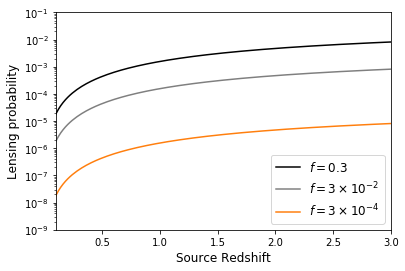

In [358]:
plot(zls, I1, color='k')
plot(zls, I2, color='k', alpha=0.5)
plot(zls, I3, color='C1')

semilogy()
xlim(0.1, 3.0)
ylim(1e-9, 0.1)
xlabel('Source Redshift', fontsize=12)
ylabel('Lensing probability', fontsize=12)
legend([r'$f=0.3$', r'$f=3\times10^{-2}$', r'$f=3\times10^{-4}$'], fontsize=12)

Another simple thing we can do, is assume each halo is assume each halo is an SIS and is parameterized only by its velocity dispersion. 

\begin{equation}
    \tau(z_s) = \int_0^{z_s} dV(z_s) \int_0^\infty d\sigma \frac{dn}{d\sigma} \times B \pi\theta_E^2(\sigma) \,\,\,\,\,\,\,\,\,\,\,(3)
\end{equation}

This equation integrates over all lenses between us and the source, 
and over all possible velecocity dispersions. Try using the function "theta_ein(M, zl=0.5, zs=1, prof='SIS', sigma=200)". Here B is magnification bias, but I will ignore that for now.

For my own clarity, I rewrite that integral as:

\begin{equation}
    \tau(z_s) = \int_0^{z_s}\!\!\int_0^\infty B \frac{dn(z_l)}{d\sigma} \times \pi\theta_E^2(z_l, z_s, \sigma) \, \,d\sigma dV(z_l) \,\,\,\,\,\,\,\,\,\,\,(3)
\end{equation}


Note: this equation comes from Eq. 30 in https://arxiv.org/pdf/1907.06830.pdf

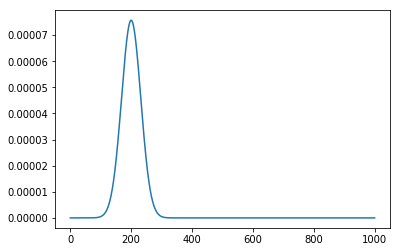

In [399]:
sigs = np.linspace(0, 1000, 1000)
var=1000
plot(sigs, n_sig(zl, sigs))